In [1]:
import sys
import re, os, path, csv
import glob

import numpy as np
import pandas as pd
from numpy import fft

import matplotlib.pyplot as plt
import matplotlib as mpl
import gif
import h5py
from numpy import fft
from larch import io, Interpreter
mylarch = Interpreter()

sys.path.insert(0, r'C:\Users\shadd\OneDrive\Documents\Python\frxas.py')

from frxas import time_domain, models, hdf5_io
import dynamic_XAS_visualization as dxas

%reload_ext autoreload
%autoreload 2
# gif.options.matplotlib["dpi"] = 200

In [2]:
direc = r'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\Energy Spectrum_0.5Hz\\'
match_str = 'E*_EtaAlign_Ir.h5'
match_str_eta = 'E*_EtaAlign_Eta.h5'
match_str_v = 'E*_EtaAlign_V.h5'
match_str_j = 'E*_EtaAlign_J.h5'

all_files = glob.glob(os.path.join(direc,match_str))
all_files.sort(key=lambda file:int(file.split('\\E')[-1].split('_E')[0]))

all_files_eta = glob.glob(os.path.join(direc,match_str_eta))
all_files_eta.sort(key=lambda file:int(file.split('\\E')[-1].split('_E')[0]))

all_files_v = glob.glob(os.path.join(direc,match_str_v))
all_files_v.sort(key=lambda file:int(file.split('\\E')[-1].split('_E')[0]))

all_files_j = glob.glob(os.path.join(direc,match_str_j))
all_files_j.sort(key=lambda file:int(file.split('\\E')[-1].split('_E')[0]))

In [3]:
models_Ir, models_Eta, models_V, models_J = [], [], [], []
for file, file_eta, file_v, file_j in zip(all_files, all_files_eta, all_files_v, all_files_j):
    models_Ir.append(hdf5_io.load_time_domain_fit(file[:-3]))
    models_Eta.append(hdf5_io.load_time_domain_fit(file_eta[:-3]))
    models_V.append(hdf5_io.load_time_domain_fit(file_v[:-3]))
    models_J.append(hdf5_io.load_time_domain_fit(file_j[:-3]))
    
meta = np.genfromtxt('..\\Feb2018 Data Fits\\Energy Spectrum_0.5Hz\\Energies_Iravgs.csv', delimiter=',',skip_header=1)
energies = meta[:,1]
Ir_avgs = meta[:,2]

In [89]:
np.max(Ir_larch)

1.4322676134975605

In [4]:
models_Eta[83]

In [4]:
Irs, Etas, Vs, Ir_actual, Zs = [], [], [], [], []
for model_Ir, model_Eta, model_V, model_J, Ir_avg in zip(models_Ir, models_Eta, models_V, models_J, Ir_avgs):
    Ns = int(model_Ir.ndata/2)
    dt = 1/(model_Ir.userkws['frequencies'][0]*-2)
    freq_in = model_Ir.userkws['freq_in']
    b = model_Ir.userkws['window_param']
    ti = np.linspace(0, dt*(Ns-1),num=Ns)
    Ns_wfm = int(1/freq_in/dt)
    
    Ir = fft.ifft(fft.ifftshift(model_Ir.eval()*(Ns*np.pi)))
    Eta = fft.ifft(fft.ifftshift(model_Eta.eval()*(Ns*np.pi)))
    V = fft.ifft(fft.ifftshift(model_V.eval()*(Ns*np.pi)))
    
    window = time_domain.gauss_window(np.ones(Ns), freq_in, ti, b)
    ti = ti[:Ns_wfm]
    
    Irs.append(Ir[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
    Etas.append(Eta[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
    Vs.append(V[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
    Ir_actual.append(Ir[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm] + Ir_avg)
    
    Z = (model_V.params['h1_re_comp'].value + 1j * model_V.params['h1_im_comp'].value) / (model_J.params['h1_re_comp'].value + 1j * model_J.params['h1_im_comp'].value)
    Zs.append(Z)
Irs = np.array(Irs)
Etas = np.array(Etas)
Vs = np.array(Vs)
Ir_actual = np.array(Ir_actual)

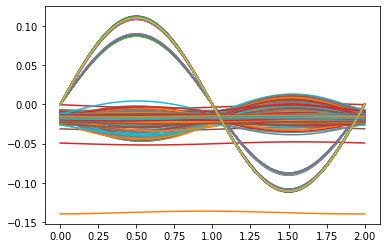

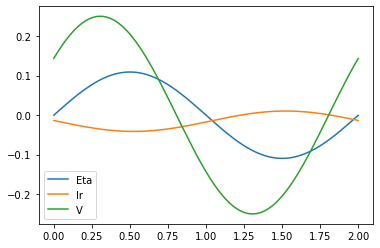

In [5]:
_, ax = plt.subplots()
maxes=[[]]
for (eta, Ir, V) in zip(Etas[:,:], Irs[:,:], Vs[:,:]):
    maxes.append([np.max(eta.real), np.max(V.real)])
    ax.plot(ti, eta.real)
    ax.plot(ti, Ir.real)    

plt.show()

_, ax = plt.subplots()
ax.plot(ti, Etas[83, :].real, label='Eta')
ax.plot(ti, Irs[83, :].real, label ='Ir')  
ax.plot(ti, Vs[83, :].real, label ='V')

ax.legend()
plt.show()

(2.3, 2.48)

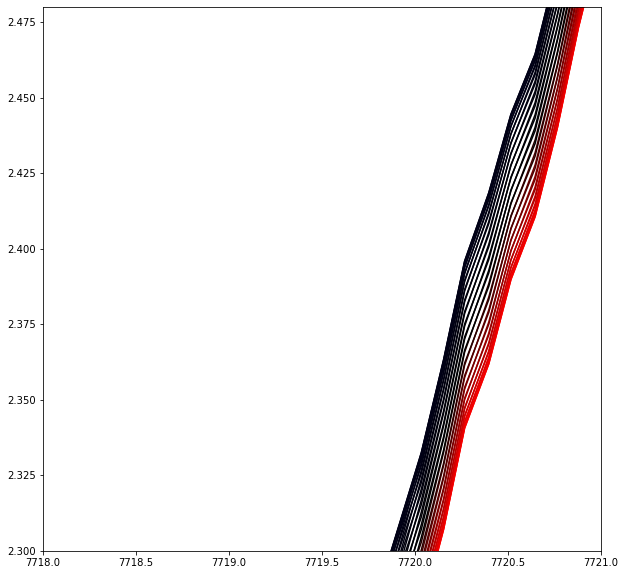

In [6]:
_, ax1 = plt.subplots( figsize=(10,10))

for i in range(0, 40):
    ax1.plot(energies, Ir_actual[:,i*50].real, color=dxas.colorfun(Etas[0,i*50].real,np.max(np.abs(Etas[0,:].real))))
ax1.set_xlim(7718, 7721)
ax1.set_ylim(2.3,2.48)

In [ ]:
deglitch = [0,1,2,6,178,179]
energies[deglitch]
deglitch_mask = np.ones((len(energies)),dtype=bool)
deglitch_mask[:] = True
deglitch_mask[deglitch] = False

In [9]:
direc = r'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\Raw_All_Eta\\'
for i, (Ir,eta) in enumerate(zip(Ir_actual[deglitch_mask].T,Etas[0])):
#     print(np.shape(Ir[None].T), np.shape(energies[deglitch_mask,None]))
    svname = direc + f'{i} Eta {eta.real*1000:.2f} mV.txt'
    svdat = np.concatenate((energies[deglitch_mask, None], Ir[None].T.real), axis=1)
#     print(svname, svdat.shape, i)
#     np.savetxt(svname, svdat, delimiter='\t', fmt='%.8e')

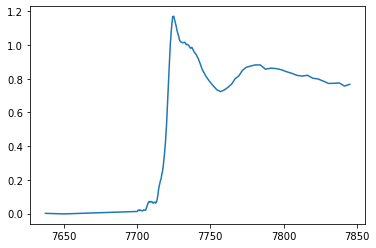

In [7]:
fname = 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\fr_XAS\\Feb2018 Data Fits\\0.5 Hz XANES by Eta\\0.5 Hz Normalized.csv'

dat = np.array(pd.read_csv(fname, delimiter=',', header=None, skiprows=1))
energies_norm = dat[:,0]
Ir_norm = dat[:,1:]
Eta_norm = -Etas[0,::50].real

fig, ax = plt.subplots()
ax.plot(energies_norm, Ir_norm[:,0])
plt.show()

In [103]:
inset_dict = {'start_energy':7719, 'stop_energy':7720.5, 'x1_adj': 0, 'x2_adj': 0, 'x_interval':0.5, 'y1_adj': 0,
                      'y2_adj': -0.05, 'y_interval': 0.06, 'x_lateral': 0.1, 'y_vertical':0}
fig = dxas.format_XANES(energies_norm, Ir_norm[:,1:], Eta_norm[1:], startE=7700,stopE=7730,
               inset_dict=inset_dict, size=(9,6), marker='')
# plt.savefig(r'Plots\\0.5 Hz XANES Spectra.png', bbox_inches='tight', dpi=400)

NameError: name 'energies_norm' is not defined

(-0.05168025445675005, 0.014510811088712766)

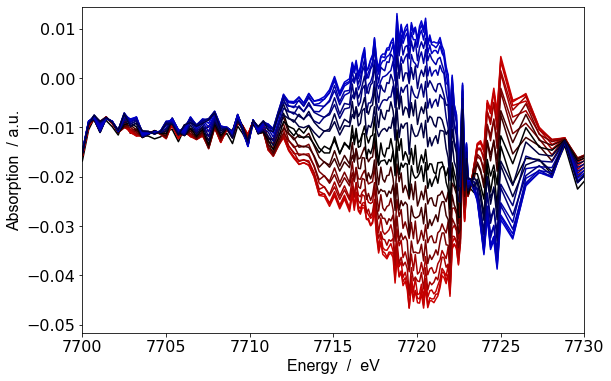

In [13]:
# Difference plot using unnormalized Ir
fig = plt.figure(constrained_layout=False, figsize=(9,6))
gs = fig.add_gridspec(7, 25)
ax1 = fig.add_subplot(gs[:, :])
max_eta = int(round(np.max(-Etas[0,:].real) * 1000, 0))
min_eta = int(round(np.min(-Etas[0,:].real) * 1000, 0))

for n, Ir in enumerate(Irs[:,1::100].T.real):
    ax1.plot(energies,Ir, color=dxas.colorfun(Etas[0,n*100].real, np.max(np.abs(Etas))))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal'}
ax1.set_ylabel(r'Absorption  / a.u.', **title_font)
ax1.set_xlabel(r'Energy  /  eV', **title_font)  
# # Plotting colorbar
# f_ax3=fig.add_subplot(gs[:5,-1])
# cdict = {'red':   [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 1.0, 1.0)],

#                  'green': [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],

#                  'blue':  [(0.0, 1.0, 1.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],}

# cmap_name = 'my_list'
# cm = mpl.colors.LinearSegmentedColormap(cmap_name, cdict, N=100)
# norm = mpl.colors.Normalize(vmin=min_eta, vmax=max_eta)
# cb1=mpl.colorbar.ColorbarBase(f_ax3, cmap=cm, norm=norm, orientation='vertical')
# cb1.set_ticks([min_eta, 0, max_eta])
# cb1.set_label('mV',rotation=0, labelpad=-3, verticalalignment='center')

xind1 = np.argwhere(energies>=7700)[0][0]
xind2 = np.argwhere(energies<=7730)[-1][0]

ylim1 = np.min(Irs[xind1:xind2,:].real)
ylim2 = np.max(Irs[xind1:xind2,:].real)
ax1.set_xlim(7700, 7730)
ax1.set_ylim(ylim1*1.1, ylim2*1.1)

# plt.savefig(r'Plots\\0.5 Hz XANES Differences.png', bbox_inches='tight', dpi=400)

(7700.0, 7740.0)

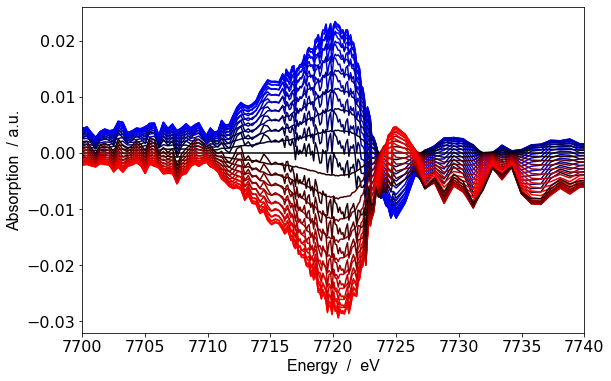

In [14]:
# Difference plot using normalized Ir
# Using Eta_norm[20] as OCV even though it's actually for +0.2 mV, since 
# Eta_norm[0] is making it look weird...

fig = plt.figure(constrained_layout=False, figsize=(9,6))
gs = fig.add_gridspec(7, 25)
ax1 = fig.add_subplot(gs[:, :])
max_eta = int(round(np.max(-Etas[0,:].real) * 1000, 0))
min_eta = int(round(np.min(-Etas[0,:].real) * 1000, 0))

for n, Ir in enumerate(Ir_norm[:,1:].T):
    ax1.plot(energies_norm, Ir - Ir_norm[:,20], color=dxas.colorfun(Eta_norm[n+1], np.max(np.abs(Eta_norm))))# color=dxas.colorfun(-Etas[0,n*100].real, np.max(np.abs(-Etas))))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal'}
ax1.set_ylabel(r'Absorption  / a.u.', **title_font)
ax1.set_xlabel(r'Energy  /  eV', **title_font)  
# # Plotting colorbar
# f_ax3=fig.add_subplot(gs[:5,-1])
# cdict = {'red':   [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 1.0, 1.0)],

#                  'green': [(0.0, 0.0, 0.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],

#                  'blue':  [(0.0, 1.0, 1.0),
#                            (0.5, 0.0, 0.0),
#                            (1.0, 0.0, 0.0)],}

# cmap_name = 'my_list'
# cm = mpl.colors.LinearSegmentedColormap(cmap_name, cdict, N=100)
# norm = mpl.colors.Normalize(vmin=min_eta, vmax=max_eta)
# cb1=mpl.colorbar.ColorbarBase(f_ax3, cmap=cm, norm=norm, orientation='vertical')
# cb1.set_ticks([min_eta, 0, max_eta])
# cb1.set_label('mV',rotation=0, labelpad=-3, verticalalignment='center')

xind1 = np.argwhere(energies>=7700)[0][0]
xind2 = np.argwhere(energies<=7730)[-1][0]

ylim1 = np.min(Irs[xind1:xind2,:].real)
ylim2 = np.max(Irs[xind1:xind2,:].real)
ax1.set_xlim(7700, 7740)
# ax1.set_ylim(ylim1*1.1, ylim2*1.1)

# plt.savefig(r'Plots\\0.5 Hz XANES Differences.png', bbox_inches='tight', dpi=400)

## Normalize XANES spectra of first harmonic, deglitched data

## Run Feb18 XANES Normalization notebook before continuing

In [ ]:
dir_path = 'C:/Users/shadd/OneDrive/Documents/Python/Xray-project/fr_XAS/Feb2018 Data Fits/0.5 Hz XANES by Eta/Raw_All_Eta/'
all_files = glob.glob(dir_path + '*Eta*')
all_files.sort(key=lambda file: int(file.split('\\')[-1].split(' Eta')[0]))

In [ ]:
ath_prj = io.create_athena(r'0.5_Hz_all_eta.prj', _larch=mylarch)
for file in all_files:
    ath_prj.add_group(dxas.larch_xafs_normalization(file))
    
ath_prj.save()

In [2]:
norm_prj = io.read_athena(r'0.5_Hz_all_eta.prj', _larch=mylarch)

In [3]:
energies, mus, Ir_larch, Eta_larch = [], [], [], []
rs, chi_mags, chi_res = [], [], []
for name, group in norm_prj._athena_groups.items():
    energies.append(group.energy)
    Ir_larch.append(group.norm)
    Eta_larch.append(dxas.group_name_to_eta(name))
    mus.append(group.mu)
    rs.append(group.r)
    chi_mags.append(group.chir_mag)
    chi_res.append(group.chir_re)

energies = dxas.transpose_list(energies)
Ir_larch = dxas.transpose_list(Ir_larch)
Eta_larch = dxas.transpose_list(Eta_larch) / 1000
mus = dxas.transpose_list(mus)
rs = dxas.transpose_list(rs)
chi_mags = dxas.transpose_list(chi_mags)
chi_res = dxas.transpose_list(chi_res)

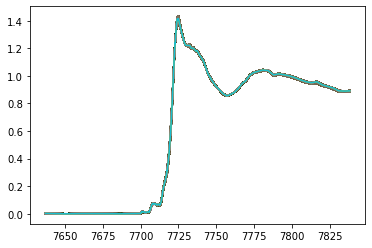

In [4]:
fig, ax = plt.subplots()
ax.plot(energies, Ir_larch)
plt.show()
# ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
# ax.set_xticklabels(['a','a','a'])  # xticks(np.arange(7700, 7800, step=10))

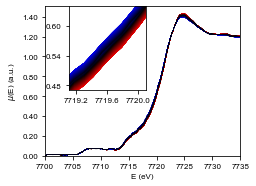

In [5]:
# Plot static spectra
inset_dict = {'start_energy':7719, 'stop_energy':7720.3, 'x1_adj': 0, 'x2_adj': 0, 'x_interval':0.5, 'y1_adj': 0.02,
                      'y2_adj': -0.08, 'y_interval': 0.01, 'x_lateral': 0.1, 'y_vertical':0}
larch_step = 4
start_ind = 2

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 8}


mpl.rc('font', **font)
fig = dxas.format_XANES(energies[:, 0], Ir_larch, Eta_larch, step=larch_step, startE=7700,stopE=7735,
               inset_dict=inset_dict, size=(3.5,2.75), marker='', colorbar=False)

plt.savefig(r'Plots\\XANES\\0.5 Hz XANES Spectra_4.svg', bbox_inches='tight', dpi=400)

In [6]:
np.max(Ir_larch)

1.4322676134975605

In [15]:
# Make animated spectra
inset_dict = {'start_energy':7719, 'stop_energy':7720.5, 'x1_adj': 0, 'x2_adj': 0, 'x_interval':0.5, 'y1_adj': 0,
                      'y2_adj': -0.05, 'y_interval': 0.06, 'x_lateral': 0.1, 'y_vertical':0}
larch_step = 20
start_ind = 2

max_eta = np.max(Eta_larch)
min_eta = np.min(Eta_larch)

# Plot data in for loop to get individual frames
frames = []
for n in np.arange(start_ind, Ir_larch.shape[-1], larch_step):
    fig = dxas.format_XANES(energies[:, 0], Ir_larch, Eta_larch, step=larch_step, startE=7700,stopE=7735,
               inset_dict=inset_dict, size=(9,6), marker='', plot_data=False)
    color = dxas.colorfun(Eta_larch[n], v_max=max_eta, v_min=min_eta)
    frames.append(dxas.XANES_gif(fig, energies[:, 0], Ir_larch[:,n], color=color))
    
gif.save(frames, 'Plots\\0.5Hz_XANES_spectra_animated.gif', duration=2,
         unit="s", between='startend', loop=True)

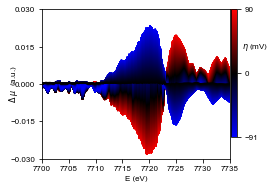

In [7]:
# Plot static difference spectra
larch_step = 4
start_ind = 2

fig = dxas.format_diffXANES(energies[:,0], Ir_larch, Eta_larch,
                            start_ind=start_ind, step=larch_step, size=(3.5, 2.75))
plt.savefig(r'Plots\\XANES\\0.5 Hz XANES Difference_1.svg', bbox_inches='tight', dpi=400)
plt.show()

In [16]:
# Make animated difference spectra
larch_step = 20
start_ind = 2

max_eta = np.max(Eta_larch - Eta_larch[start_ind])
min_eta = np.min(Eta_larch - Eta_larch[start_ind])

# Plot data in for loop to get individual frames
frames = []
for n in np.arange(start_ind, Ir_larch.shape[-1], larch_step):
    fig = dxas.format_diffXANES(energies[:,0], Ir_larch, Eta_larch, 
                                start_ind=start_ind, step=larch_step, size=(9,6),
                                plot_data=False)
    color = dxas.colorfun(Eta_larch[n] - Eta_larch[start_ind], v_max = max_eta, v_min = min_eta)
    frames.append(dxas.diffXANES_gif(fig, energies[:, 0], Ir_larch, n, start_ind, color=color))
    
gif.save(frames, 'Plots\\0.5Hz_XANES_difference_animated.gif', duration=2, unit="s", between='startend')

(100, 174) -90.92 89.75


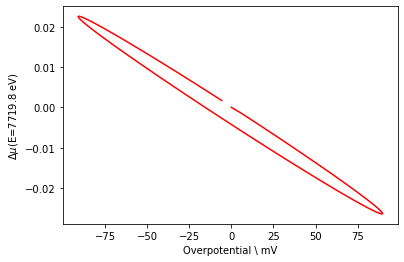

In [24]:
fig = dxas.plot_lissajou(energies, Ir_larch, Eta_larch, plot_e=7719.8, start_ind=2, step=larch_step, color=(1,0,0))
dum_ax = fig.axes[0]
# dum_ax.set_xlim(-.01, .01)
plt.show()

In [18]:
larch_step = 20
freq = 0.5
sin_frames = []
t = np.linspace(0, 2/freq, num=len(Eta_larch))
amp = np.max(np.abs(Eta_larch))
wfm = amp * np.sin(2 * np.pi * freq * t)

for n in np.arange(start_ind, Ir_larch.shape[-1], larch_step):
    wfm_fig = dxas.format_wfm(freq, Eta_larch, t_fin=2/freq)
    sin_frames.append(dxas.plot_wfm(wfm_fig, t, wfm, Eta_larch, n))
    
gif.save(sin_frames, 'Plots\\0.5Hz_Wfm2.gif', duration=4, unit="s", between='startend')

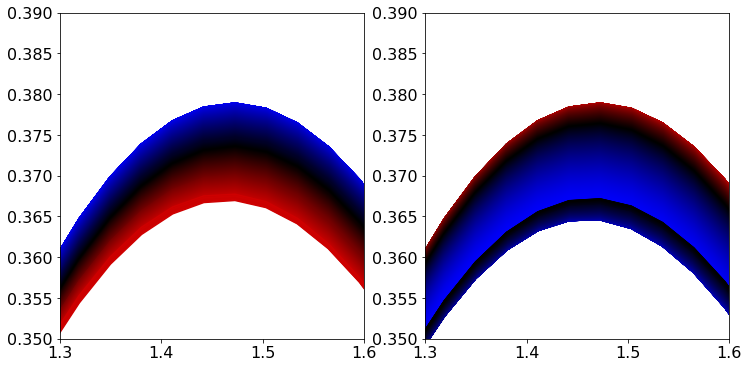

In [77]:
_, (ax1, ax2)  = plt.subplots(ncols=2, figsize=(12,6))
st = 1999
end = 699
for i, eta in enumerate(Eta_larch[st:end:-1]):
    
    color = dxas.colorfun(eta, np.max(Eta_larch), np.min(Eta_larch))
    ax1.plot(rs[:, -(i+end)], chi_mags[:, -(i+end)], color=color)

for i, eta in enumerate(Eta_larch):
    
    color = dxas.colorfun(eta, np.max(Eta_larch), np.min(Eta_larch))
    ax2.plot(rs[:, i], chi_mags[:, i], color=color)

ax1.set_xlim(1.3, 1.6)
ax1.set_ylim(.35, 0.39)
ax2.set_xlim(1.3, 1.6)
ax2.set_ylim(.35, 0.39)
plt.show()

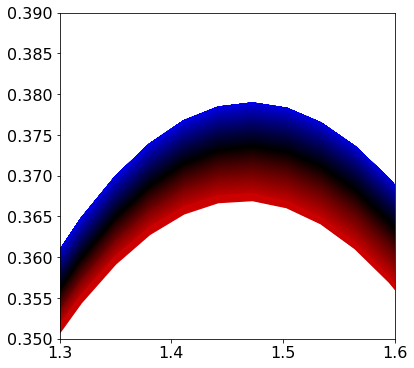

In [79]:
_, ax1  = plt.subplots(figsize=(6,6))
st = 1999
end = 699
for i, eta in enumerate(Eta_larch[st:end:-1]):
    
    color = dxas.colorfun(eta, np.max(Eta_larch), np.min(Eta_larch))
    ax1.plot(rs[:, -(i+end)], chi_mags[:, -(i+end)], color=color)

ax1.set_xlim(1.3, 1.6)
ax1.set_ylim(.35, 0.39)

plt.savefig('Plots\\0.5_Chir_inset.png', bbox_inches='tight', dpi=300)
plt.show()

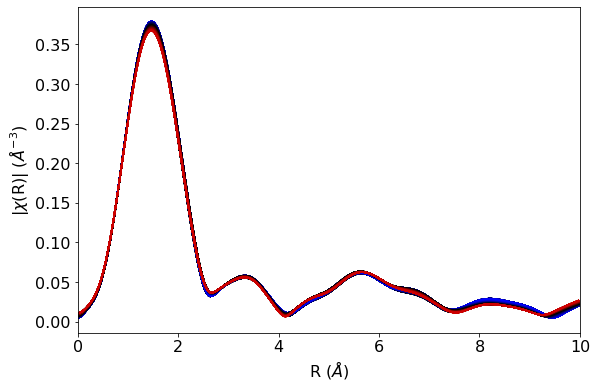

In [87]:
_, ax1  = plt.subplots(figsize=(9,6))
st = 1999
end = 699
for i, eta in enumerate(Eta_larch[st:end:-1]):
    
    color = dxas.colorfun(eta, np.max(Eta_larch), np.min(Eta_larch))
    ax1.plot(rs[:, -(i+end)], chi_mags[:, -(i+end)], color=color)

ax1.set_xlim(0, 10)
# ax1.set_ylim(.35, 0.39)
ax1.set_xlabel(r'R ($\AA$)')
ax1.set_ylabel('|$\chi$(R)| ($\AA^{-3}$)')
plt.savefig('Plots\\0.5_Chir_main.png', bbox_inches='tight', dpi=300)
plt.show()

(0.35, 0.4)

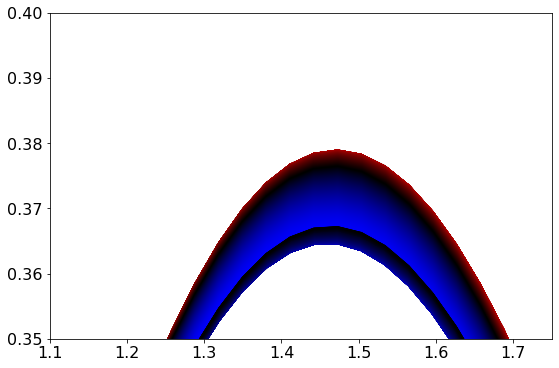

In [45]:
_, ax  = plt.subplots(figsize=(9,6))
for i, eta in enumerate(Eta_larch):
    color = dxas.colorfun(eta, np.max(Eta_larch), np.min(Eta_larch))
    ax.plot(rs[:, i], chi_mags[:, i], color=color)
    
ax.set_xlim(1.1, 1.75)
ax.set_ylim(.35, 0.4)

In [20]:
from larch import xafs

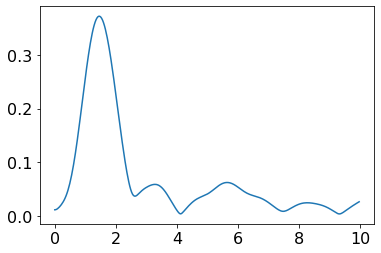

In [29]:
plt.plot(norm_prj._athena_groups['d_0_Eta_n0_09_mV_txt'].r ,norm_prj._athena_groups['d_0_Eta_n0_09_mV_txt'].chir_mag)

In [50]:
def format_XAFS(energies, Irs, etas, step=1, start_ind=0, stop_ind=None, marker='.',
                 startE=7705, stopE=7730, size=(9, 6),
                 plot_data=True, colorbar=True):
# Finding max and min of Ir across all data sets for setting plot limits
    Ir_abs_max = np.max(Irs)
    Ir_abs_min = np.round(np.min(Irs[np.argwhere(energies>=startE)[0][0]]), 2)

    # Finding max and min of eta (or voltage) for setting color bar limits
    max_eta = np.max(etas)
    min_eta = np.min(etas)

    ## Plotting full XANES spectra
    fig = plt.figure(constrained_layout=False, figsize=size)
    gs = fig.add_gridspec(7, 25)
    if colorbar:
        f_ax1 = fig.add_subplot(gs[:, :-1])
           # Area for inset
        fig = add_colorbar(fig, gs, max_eta, min_eta)
    else:
        f_ax1 = fig.add_subplot(gs[:, :])
            # Area for inset
    

    ## Choosing plot limits for inset
    xind1=np.argwhere(energies>=inset_dict['start_energy'])[0]
    xind2=np.argwhere(energies<=inset_dict['stop_energy'])[-1]

    x1=round(energies[xind1][0])
    x2=round(energies[xind2][0])

    y1=round(Irs[xind1,0][0]*.95,2)
    y2=round(Irs[xind2,0][0]*1.05,2)
    
    if stop_ind is None:
        stop_ind = Irs.shape[-1]

        
    if plot_data:
        for n in range(start_ind, stop_ind, step):
            color = colorfun(etas[n], max_eta, min_eta)
            fig = plot_XAFS_data(fig, energies, Irs[:, n], color=color)

    f_ax1.set(xlim=[startE,stopE], ylim=[.97 * Ir_abs_min, 1.05 * Ir_abs_max])
    f_ax1.set_ylabel(r'normalized $\mu$(E)  / a.u.', **title_font)
    f_ax1.set_xlabel(r'Energy  /  eV', **title_font)

    
    return fig

def plot_XAFS_data(fig, energies, Irs, color=(0,0,0)):
    ax1 = fig.axes[0]
    
    # Main Spectra
    ax1.plot(energies, Irs, color=color, linestyle='-', linewidth=1,
             marker='', markersize=.3, label='a')
    return fig

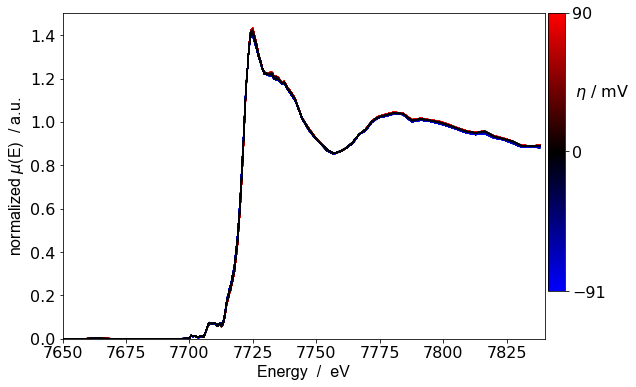

In [59]:
fig = dxas.format_XAFS(energies[:, 0], Ir_larch, Eta_larch, step=larch_step, startE=7650,stopE=7840,
                size=(9,6), marker='')

In [64]:
# Make animated spectra
inset_dict = {'start_energy':7719, 'stop_energy':7720.5, 'x1_adj': 0, 'x2_adj': 0, 'x_interval':0.5, 'y1_adj': 0,
                      'y2_adj': -0.05, 'y_interval': 0.06, 'x_lateral': 0.1, 'y_vertical':0}
larch_step = 20
start_ind = 2

max_eta = np.max(Eta_larch)
min_eta = np.min(Eta_larch)

# Plot data in for loop to get individual frames
frames = []
    
for n in np.arange(start_ind, Ir_larch.shape[-1], larch_step):
    fig = dxas.format_XAFS(energies[:, 0], Ir_larch, Eta_larch, step=larch_step, startE=7650,stopE=7840,
                           size=(9,6), marker='', plot_data=False)
    color = dxas.colorfun(Eta_larch[n], v_max=max_eta, v_min=min_eta)
    frames.append(dxas.XAFS_gif(fig, energies[:, 0], Ir_larch[:,n], color=color))
    
# gif.save(frames, 'Plots\\0.5Hz_XAFS_spectra_animated.gif', duration=2,
#          unit="s", between='startend', loop=True)

#     fig = dxas.format_XAFS(energies[:, 0], Ir_larch, Eta_larch, step=larch_step, startE=7650,stopE=7840,
#                 size=(9,6), marker='')
#     color = dxas.colorfun(Eta_larch[n], v_max=max_eta, v_min=min_eta)
#     frames.append(dxas.XAFS_gif(fig, energies[:, 0], Ir_larch[:,n], color=color))
    
gif.save(frames, 'Plots\\0.5Hz_XAFS_spectra_animated.gif', duration=2,
         unit="s", between='startend', loop=True)